In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense
import warnings
warnings.filterwarnings("ignore")

In [3]:
# 5 Stocks for training
app_stock = pd.read_csv('/content/drive/MyDrive/Stocks Data/Apple_stock.csv')
msft_stock = pd.read_csv('/content/drive/MyDrive/Stocks Data/Microsoft_stock.csv')
googl_stock = pd.read_csv('/content/drive/MyDrive/Stocks Data/ALPHABET_stock.csv')
xom_stock = pd.read_csv('/content/drive/MyDrive/Stocks Data/EXXON_stock.csv')
fang_stock = pd.read_csv('/content/drive/MyDrive/Stocks Data/Diamondback_stock.csv')

# 5 Stocks for testing
wmt_stock = pd.read_csv('/content/drive/MyDrive/Stocks Data/Walmart_stock.csv')
dg_stock = pd.read_csv('/content/drive/MyDrive/Stocks Data/DG_stock.csv')
jnj_stock = pd.read_csv('/content/drive/MyDrive/Stocks Data/Johnson&Johnson_stock.csv')
jpm_stock = pd.read_csv('/content/drive/MyDrive/Stocks Data/JPMorgan_stock.csv')
cfg_stock = pd.read_csv('/content/drive/MyDrive/Stocks Data/CitizensFinancialGroup_stock.csv')

In [4]:
# Checking with 1 Stock
print("Checking with Apple Stock:\n")
app_stock

Checking with Apple Stock:



,Date,Adj Close,Stock Name
0,2013-01-02,16.647184,Apple
1,2013-01-03,16.437059,Apple
2,2013-01-04,15.979206,Apple
3,2013-01-07,15.885221,Apple
4,2013-01-08,15.927964,Apple
...,...,...,...
3013,2024-12-20,253.877594,Apple
3014,2024-12-23,254.655716,Apple
3015,2024-12-24,257.578674,Apple
3016,2024-12-26,258.396667,Apple


In [5]:
app_stock['Date'] = pd.to_datetime(app_stock['Date'])
app_stock.sort_values('Date', inplace=True)

In [6]:
# Use Adj closing price and create train-test split
apple_prices = app_stock['Adj Close'].values
train_size = int(len(apple_prices) * 0.8)
train, test = apple_prices[:train_size], apple_prices[train_size:]

print(f"80% of Apple Training Stocks size: {len(train)}")
print(f"20% of Apple Testing Stocks  size: {len(test)}")

80% of Apple Training Stocks size: 2414
20% of Apple Testing Stocks  size: 604


In [7]:
train

array([ 16.64718437,  16.4370594 ,  15.97920609, ..., 158.95974731,
       157.48345947, 163.50682068])

In [8]:
test

array([163.19187927, 162.9651947 , 162.49209595, 162.54138184,
       166.79910278, 166.05989075, 169.61784363, 170.6920929 ,
       170.53439331, 172.03248596, 171.63822937, 169.04620361,
       165.15319824, 164.8180542 , 165.11375427, 167.5776825 ,
       161.26014709, 159.05244446, 156.61807251, 154.95243835,
       155.6817627 , 153.56277466, 152.3012085 , 153.71061707,
       152.23223877, 155.1002655 , 161.07286072, 151.6211853 ,
       153.06997681, 150.17237854, 148.52645874, 152.25195312,
       154.63703918, 151.50291443, 150.5370636 , 148.26034546,
       148.59547424, 149.57118225, 147.67884827, 140.42504883,
       136.20675659, 140.39546204, 143.99281311, 144.28846741,
       143.33247375, 138.06947327, 138.39476013, 136.97549438,
       136.34474182, 140.9276886 , 136.38418579, 140.35606384,
       141.67669678, 141.78514099, 141.32189941, 145.14596558,
       147.29449463, 150.14282227, 147.19593811, 142.71156311,
       153.49378967, 151.12838745, 148.47717285, 142.93

In [9]:
# Stationarity check when the series are stationary
def make_series_stationary(series, max_diffs=2):
    current_series = series.copy()
    diffs_applied = 0

    for i in range(max_diffs + 1):
        # Perform Dickey-Fuller test
        result = adfuller(current_series)
        p_value = result[1]

        print(f"\nTest {i+1}:")
        print(f"ADF Statistic: {result[0]:.4f}")
        print(f"p-value: {p_value:.4f}")
        print("Critical Values:")
        for key, value in result[4].items():
            print(f"\t{key}: {value:.4f}")

        if p_value <= 0.05:
            print("\nSeries is now stationary")
            return current_series, diffs_applied
        elif i < max_diffs:
            print("\nSeries is not stationary. Applying differencing...")
            current_series = np.diff(current_series)
            diffs_applied += 1

    raise ValueError(f"Series could not be made stationary after {max_diffs} differences")

# Make the training series stationary
try:
    print("Checking stationarity of original series...")
    train_stationary, diffs_needed = make_series_stationary(train)

    print(f"\nSuccessfully made series stationary with {diffs_needed} difference(s)")
    print("Proceeding with next steps...")

except ValueError as e:
    print(f"\nError: {e}")
    print("Cannot proceed with analysis - series is not stationary")


Checking stationarity of original series...

Test 1:
ADF Statistic: 0.8245
p-value: 0.9920
Critical Values:
	1%: -3.4331
	5%: -2.8628
	10%: -2.5674

Series is not stationary. Applying differencing...

Test 2:
ADF Statistic: -8.9329
p-value: 0.0000
Critical Values:
	1%: -3.4331
	5%: -2.8628
	10%: -2.5674

Series is now stationary

Successfully made series stationary with 1 difference(s)
Proceeding with next steps...


Text(0.5, 1.0, 'ACF - Original Series')

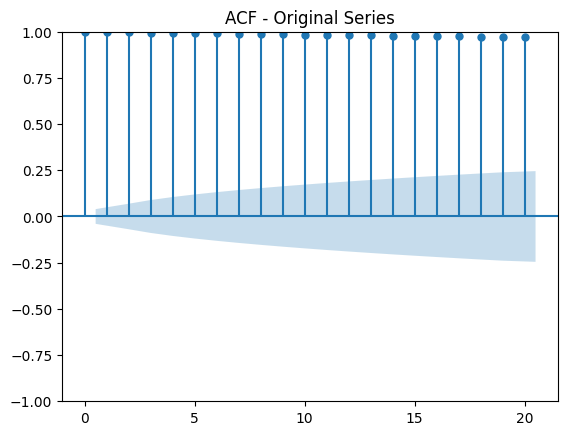

In [10]:
# ACF and PACF plots for original series
plot_acf(train, lags=20)
plt.title('ACF - Original Series')

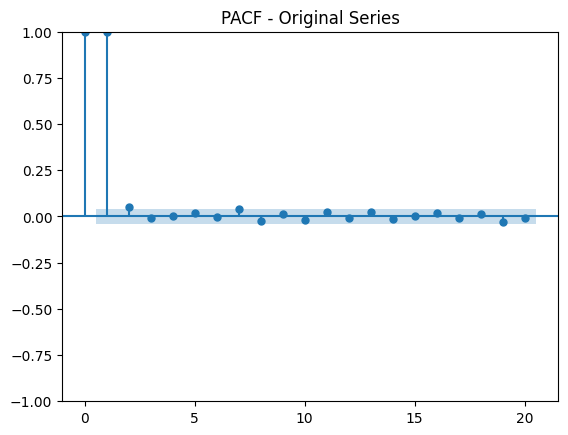

In [11]:
plot_pacf(train, lags=20, method='ywm')
plt.title('PACF - Original Series')
plt.show()

Text(0.5, 1.0, 'ACF - Differenced Series')

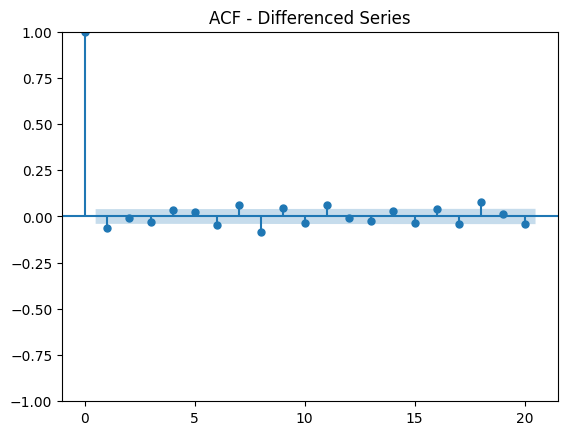

In [12]:
plot_acf(train_stationary, lags=20)
plt.title('ACF - Differenced Series')

Text(0.5, 1.0, 'PACF - Differenced Series')

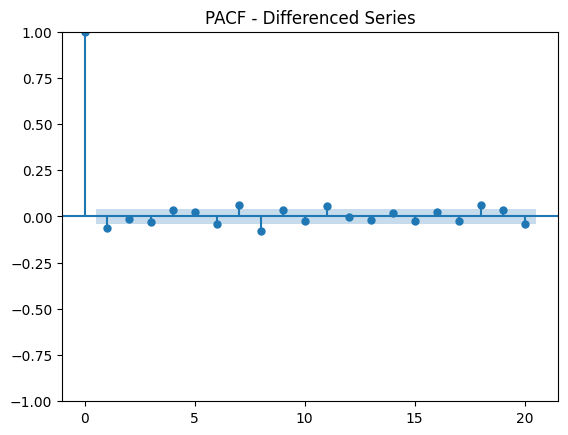

In [13]:
plot_pacf(train_stationary, lags=20, method='ywm')
plt.title('PACF - Differenced Series')

In [14]:
# Function to evaluate ARIMA model
def evaluate_arima_model(train, test, order):
    history = [x for x in train]
    predictions = list()

    # Walk-forward validation
    for t in range(len(test)):
        model = ARIMA(history, order=order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])

    # Calculate performance metrics
    r2 = r2_score(test, predictions)
    mae = mean_absolute_error(test, predictions)
    mse = mean_squared_error(test, predictions)
    rmse = np.sqrt(mse)

    return predictions, r2, mae, mse, rmse

In [15]:
# Try different ARIMA orders based on ACF/PACF analysis
orders_to_try = [
    (1,0,1),  # Standard starting point
    (2,1,2),  # More complex model
    (0,1,1),  # MA only
    (1,1,0),  # AR only
    (5,1,0),  # Higher AR
    (0,1,5),  # Higher MA
]

best_r2 = -np.inf
best_order = None
best_predictions = None

for order in orders_to_try:
    try:
        print(f"\nEvaluating ARIMA{order}...")
        predictions, r2, mae, mse, rmse = evaluate_arima_model(train, test, order)
        print(f"R²: {r2:.4f}| MAE: {mae:.4f}| MSE: {mse:.4f}| RMSE: {rmse:.4f}")

        if r2 > best_r2:
            best_r2 = r2
            best_order = order
            best_predictions = predictions
    except:
        continue

print(f"\nBest model: ARIMA{best_order} with R²: {best_r2:.4f}")


Evaluating ARIMA(1, 0, 1)...
R²: 0.9919| MAE: 2.0054| MSE: 7.3423| RMSE: 2.7097

Evaluating ARIMA(2, 1, 2)...
R²: 0.9918| MAE: 2.0094| MSE: 7.3961| RMSE: 2.7196

Evaluating ARIMA(0, 1, 1)...
R²: 0.9919| MAE: 2.0034| MSE: 7.3369| RMSE: 2.7087

Evaluating ARIMA(1, 1, 0)...
R²: 0.9919| MAE: 2.0032| MSE: 7.3357| RMSE: 2.7085

Evaluating ARIMA(5, 1, 0)...
R²: 0.9919| MAE: 2.0116| MSE: 7.3652| RMSE: 2.7139

Evaluating ARIMA(0, 1, 5)...
R²: 0.9918| MAE: 2.0114| MSE: 7.3689| RMSE: 2.7146

Best model: ARIMA(1, 1, 0) with R²: 0.9919


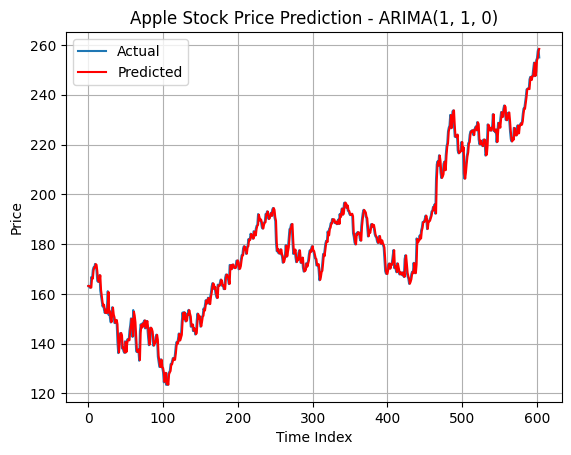

In [30]:
# Plot best model results
plt.plot(test, label='Actual')
plt.plot(best_predictions, color='red', label='Predicted')
plt.title(f'Apple Stock Price Prediction - ARIMA{best_order}')
plt.xlabel('Time Index')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
# Print metrics for best model
print("\n=== Best Model Performance ===")
print(f"ARIMA Order: {best_order}")
print(f"ARIMA - R² Score: {best_r2:.4f}")
print(f"ARIMA - MAE     : {mean_absolute_error(test, best_predictions):.4f}")
print(f"ARIMA - MSE     : {mean_squared_error(test, best_predictions):.4f}")
print(f"ARIMA - RMSE    : {np.sqrt(mean_squared_error(test, best_predictions)):.4f}")


=== Best Model Performance ===
ARIMA Order: (1, 1, 0)
ARIMA - R² Score: 0.9919
ARIMA - MAE     : 2.0032
ARIMA - MSE     : 7.3357
ARIMA - RMSE    : 2.7085


In [18]:
def cumulative_return(prices):
    return (prices / prices[0]) - 1

## Convert forecast and test_series to NumPy arrays for calculating cumulative return
forecast_arima = np.array(best_predictions)
test_series_array = np.array(test)

cum_return_actual_arima = cumulative_return(test_series_array)
cum_return_pred_arima = cumulative_return(forecast_arima)

# Print first 10 predictions vs actual
print("\nFirst 10 Predictions vs Actual:")
for i in range(10):
    print(f"Day {i+1}: Actual = {test[i]:.2f}, Predicted = {best_predictions[i]:.2f}")


First 10 Predictions vs Actual:
Day 1: Actual = 163.19, Predicted = 163.16
Day 2: Actual = 162.97, Predicted = 163.21
Day 3: Actual = 162.49, Predicted = 162.98
Day 4: Actual = 162.54, Predicted = 162.52
Day 5: Actual = 166.80, Predicted = 162.54
Day 6: Actual = 166.06, Predicted = 166.55
Day 7: Actual = 169.62, Predicted = 166.10
Day 8: Actual = 170.69, Predicted = 169.41
Day 9: Actual = 170.53, Predicted = 170.63
Day 10: Actual = 172.03, Predicted = 170.54


In [19]:
app_stock = pd.read_csv('/content/drive/MyDrive/Stocks Data/Apple_stock.csv')
app_stock['Date'] = pd.to_datetime(app_stock['Date'])
app_stock.sort_values('Date', inplace=True)
train_app = app_stock['Adj Close'].values # Set train to the actual training data

In [20]:
train_app.shape

(3018,)

In [21]:
train_app[:5]

array([16.64718437, 16.4370594 , 15.97920609, 15.88522148, 15.92796421])

In [22]:
train_app[5:]

array([ 15.67903233,  15.87338924,  15.77606201, ..., 257.57867432,
       258.39666748, 254.97492981])

In [24]:
three_months_stock = pd.read_csv('/content/drive/MyDrive/Stocks Data/Apple3Months_Stock.csv')
three_months_stock

,Date,Adj Close,Stock Name
0,2025-01-02,243.263199,Apple_3Months
1,2025-01-03,242.774368,Apple_3Months
2,2025-01-06,244.410416,Apple_3Months
3,2025-01-07,241.627136,Apple_3Months
4,2025-01-08,242.115952,Apple_3Months
5,2025-01-10,236.280045,Apple_3Months
6,2025-01-13,233.835922,Apple_3Months
7,2025-01-14,232.718613,Apple_3Months
8,2025-01-15,237.297562,Apple_3Months
9,2025-01-16,227.710693,Apple_3Months


In [25]:

best_arima_order = (1,0,1)
final_model = ARIMA(train_app, order=best_arima_order)
final_model_fit = final_model.fit()

three_months_test = three_months_stock['Adj Close'].values

# Make predictions for the 3 months period
predictions = final_model_fit.forecast(steps=len(three_months_test))

In [26]:
# Calculate cumulative returns
def calculate_cumulative_returns(prices):
    return (prices / prices[0] - 1) * 100

actual_returns = calculate_cumulative_returns(three_months_test)
predicted_returns = calculate_cumulative_returns(predictions)

results = pd.DataFrame({
    'Date': three_months_stock['Date'],
    'Actual Price': three_months_test,
    'Predicted Price': predictions,
    'Actual Returns (%)': actual_returns,
    'Predicted Returns (%)': predicted_returns
})

In [27]:
print("3 Months Apple Stock - Actual vs Predicted:")
results

3 Months Apple Stock - Actual vs Predicted:


,Date,Actual Price,Predicted Price,Actual Returns (%),Predicted Returns (%)
0,2025-01-02,243.263199,255.001088,0.000000,0.000000
1,2025-01-03,242.774368,254.982418,-0.200947,-0.007322
2,2025-01-06,244.410416,254.963749,0.471595,-0.014643
3,2025-01-07,241.627136,254.945083,-0.672548,-0.021963
4,2025-01-08,242.115952,254.926418,-0.471607,-0.029282
5,2025-01-10,236.280045,254.907756,-2.870617,-0.036601
6,2025-01-13,233.835922,254.889096,-3.875340,-0.043918
7,2025-01-14,232.718613,254.870437,-4.334641,-0.051235
8,2025-01-15,237.297562,254.851781,-2.452339,-0.058552
9,2025-01-16,227.710693,254.833126,-6.393283,-0.065867
